In [1]:
%load_ext autoreload

%autoreload 2
import sys, glob
import numpy as np
import matplotlib.pyplot as plt
import see_fits
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
from scipy.ndimage import gaussian_filter
sys.path.append('../modules')
import covariance as covar
import utils
import abundance as cl_count
import forecast
import pyccl as ccl
import edit
import h5py
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

In [2]:
label = 'sup_5e14Msun'
forecastF=edit.load_pickle('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Fisher_covariance_'+label+'.pickle')

In [3]:
def cov_freq(nz, nm):
    cov_gauss=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/'+label+f'_Covariance_cluster_abudance_{nz}x{nm}.pickle')
    Abundance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/'+label+f'_Abundance_{nz}x{nm}.pickle')
    cov_poiss=np.diag(Abundance.flatten())
    SigmaPGP = np.linalg.inv(cov_poiss) @ (cov_gauss @ np.linalg.inv(cov_poiss))
    
    f=forecast.Forecast()
    z_grid = np.linspace(0.18, 1.3, 2000)
    logm_grid = np.linspace(np.log10(5e14),15.6, 2000)
    z_corner = np.linspace(0.2, 1.2, nz + 1)
    logm_corner = np.linspace(np.log10(5e14), 15.6, nm + 1)
    Z_bin = binning(z_corner)
    logMass_bin = binning(logm_corner)
    clc = cl_count.ClusterAbundance()
    clc.sky_area = (0.25)*4*np.pi
    clc.f_sky = clc.sky_area/(4*np.pi)
    clc.z_grid=z_grid
    clc.logm_grid=logm_grid
    def model(theta):
        "predictiing cluster count"
        Om_v, s8_v = theta
        #re-compute ccl cosmology
        cosmo_new = ccl.Cosmology(Omega_c = Om_v - 0.048254, Omega_b = 0.048254, 
                                  h = 0.6777, sigma8 = s8_v, n_s=0.96)
        massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
        hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo_new, mass_def=massdef)
        clc.set_cosmology(cosmo = cosmo_new, hmd = hmd, massdef = massdef)
        #re-compute integrand
        clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
        return clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, 
                                        method = 'simps')
    def model_flat(theta):
        return model(theta).flatten()
    
    d_Abundance=forecast.first_derivative(True_value, model, (nz,nm), delta = 1e-5)
    return forecast.cov_Frequentist(forecastF[f'{nz}zx{nm}m']['Poissonian'], d_Abundance, SigmaPGP)

In [4]:
binnings=['100zx100m']

In [5]:
covFreq={b:None for b in binnings}

In [6]:
covFreq[binnings[0]] = cov_freq(100, 100)

In [7]:
covFreq['100zx100m'][0,0]**.5

0.0071600499107642756

In [8]:
file = glob.glob('/sps/lsst/users/cpayerne/1000xsimulations/analysis/100zx100m/mean_dispersion_sup_5e14Msun/MPG*')

In [9]:
len(file)

998

In [10]:
likelihood=['Poissonian','Gaussian', 'MPG']
cosmology = {binnings[i]:{likelihood_:None for likelihood_ in likelihood} for i in range(len(binnings))}
for b in binnings:
    try:
        cosmology[b]['Poissonian']=see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion_'+label+'/P*')
        cosmology[b]['Gaussian']  =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion_'+label+'/Gaussian*')
        cosmology[b]['MPG']       =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion_'+label+'/MPG*')
    except: 
        print(1)
        continue

In [11]:
cosmology['100zx100m']['MPG']

Om,s8,Om_std,s8_std,"cov [2,2]"
float64,float64,float64,float64,float64
0.30274880126412873,0.8310344177148841,0.007141447689053101,0.0026090301349293117,5.100027509548187e-05 .. 6.807038244969262e-06
0.30949747405936406,0.8288295397761878,0.0071462241667768775,0.002612788085393618,5.1068519841825876e-05 .. 6.826661579174847e-06
0.31234699451504677,0.8288362697786292,0.007136544680838065,0.002624211928811754,5.093026998159807e-05 .. 6.886488247317907e-06
0.31566675514829895,0.8273764983909717,0.007231770898238554,0.002614854363641962,5.2298510324610064e-05 .. 6.837463343057408e-06
0.3012224367534678,0.8317737163249179,0.007011273788820787,0.0025808377203671573,4.9157960141805394e-05 .. 6.660723338869945e-06
0.30388505271412336,0.8279875537554352,0.007175144032698494,0.0026042721599556532,5.14826918899688e-05 .. 6.782233483120084e-06
0.2992134984945605,0.8322467401504413,0.006907440277222038,0.002550677227420632,4.771273118338926e-05 .. 6.505954318482204e-06
0.3016101281425514,0.830182928785717,0.0071193441868935906,0.00258158552428987,5.068506165145556e-05 .. 6.664583819223003e-06
0.30263074543621893,0.8309563959382787,0.007136225609068868,0.002603963055775436,5.0925715943530336e-05 .. 6.780623595843345e-06


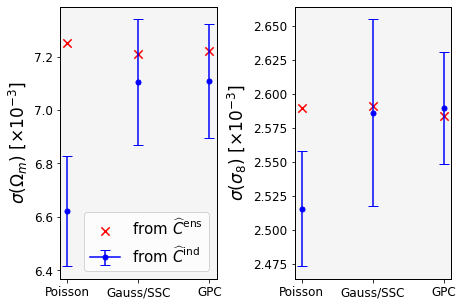

In [28]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
title = ['Poisson', 'Gauss/SSC', 'GPC']
fig, ax=plt.subplots(1, 2, figsize=(7,5))
ax[0].set_facecolor("whitesmoke")
ax[1].set_facecolor("whitesmoke")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=.4)
plt.rcParams['axes.linewidth']= 1
err=1e3
for i,l in enumerate(likelihood):
    Om=cosmology['100zx100m'][l]['Om']
    Omstd=cosmology['100zx100m'][l]['Om_std']
    s8=cosmology['100zx100m'][l]['s8']
    s8std=cosmology['100zx100m'][l]['s8_std']
    ax[0].errorbar(i, err*np.mean(Omstd), yerr=err*np.std(Omstd), marker='o', c='b', markersize=5, capsize=5)
    ax[1].errorbar(i, err*np.mean(s8std), yerr=err*np.std(s8std), marker='o', c='b', markersize=5, capsize=5)
    try:
        coeff = 1#(1/10)**.5
        cov_Fisher=forecastF['100zx100m'][l]
        #ax[0].scatter(i,err*cov_Fisher[0,0]**.5/coeff, marker='o', s=100, facecolors='none',edgecolor='k',linewidth=2)
       # ax[1].scatter(i,err*cov_Fisher[1,1]**.5/coeff, marker='o', s=100, facecolors='none',edgecolor='k',linewidth=2)
    except: a=1
    #if l=='Poissonian':
       # ax[0].scatter(i,err*covFreq['100zx100m'][0,0]**.5, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2)
       # ax[1].scatter(i,err*covFreq['100zx100m'][1,1]**.5, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2)
    ax[0].scatter(i,err*np.std(Om), marker='x', c='r', s=70)
    ax[1].scatter(i,err*np.std(s8), marker='x', c='r', s=70)

ax[0].errorbar([],[], yerr=[], marker='o', c='b', markersize=5, capsize=5, label=r'from $\widehat{C}^{\rm ind}$')
#ax[0].scatter([],[], marker='o',s=100, facecolors='none',edgecolor='k',linewidth=2, label='Fisher forecast')
#ax[0].scatter([],[], marker='s',s=100, facecolors='none',edgecolor='k',linewidth=2, label='Ensemble forecast')
ax[0].scatter([], [], marker='x', c='r', s=70, label=r'from $\widehat{C}^{\rm ens}$')
ax[0].legend(frameon=True,fontsize=15, loc='lower right')
x1 = [0,1,2]
squad = title
for i in range(2):
    ax[i].set_xticks(x1)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 12)
    ax[i].set_xticklabels(squad, fontsize=12)
ax[0].set_ylabel(r'$\sigma(\Omega_m)\ [\times 10^{-3}]$', fontsize = 17)
ax[1].set_ylabel(r'$\sigma(\sigma_8)\ [\times 10^{-3}]$', fontsize = 17)
#ax[0].set_xticklabels(ax.get_xticks(), rotation = 50)
plt.savefig('std_high_mass.pdf', bbox_inches='tight', dpi=300)